##  **FLO Customer Lifetime Value Prediction with BG-NBD & Gamma-Gamma** 

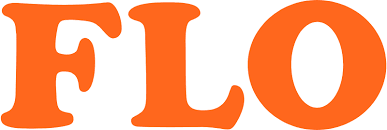

# **Business Problem**

FLO wants to determine a roadmap for its sales and marketing activities. In order for the company to make a medium-long term plan, the potential value that existing customers will provide to the company in the future needs to be estimated.

## **The Data Set Story**

The dataset consists of information obtained from the past shopping behavior of customers who made their last purchases as OmniChannel (both online and offline shopping) in 2020 - 2021.

**Features in the Dataset:**

* **master_id:** Unique customer number
* **order_channel:** Which channel is used for the shopping platform (Android, ios, Desktop, Mobile, Offline)
* **last_order_channel:** The channel where the last shopping was done
* **first_order_date:** The customer's first shopping date
* **last_order_date:** The customer's last shopping date
* **last_order_date_online:** The customer's last shopping date on the online platform
* **last_order_date_offline:** The customer's last shopping date on the offline platform
* **order_num_total_ever_online:** The total number of online shoppings made by the customer
* **order_num_total_ever_offline:** The total number of offline shoppings made by the customer
* **customer_value_total_ever_offline:** The total amount of money paid by the customer for offline shopping
* **customer_value_total_ever_online:** The total amount of money paid by the customer for online shopping
* **interested_in_categories_12:** List of categories the customer has shopped in the last 12 months

In [1]:
pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 15.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

In [3]:
# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# Load Data (Kaggle Path)
df = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")

In [5]:
# writing a function to look at the overall picture
def check_df(dataframe, head=10):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Columns #####################")
    print(dataframe.columns)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Columns #####################
Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date',
       'last_order_date', 'last_order_date_online', 'last_order_date_offline',
       'order_num_total_ever_online', 'order_num_total_ever_offline',
       'customer_value_total_ever_offline', 'customer_value_total_ever_online',
       'interested_in_categories_12'],
      dtype='object')
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_to

## **Data Preparation & Feature Engineering**

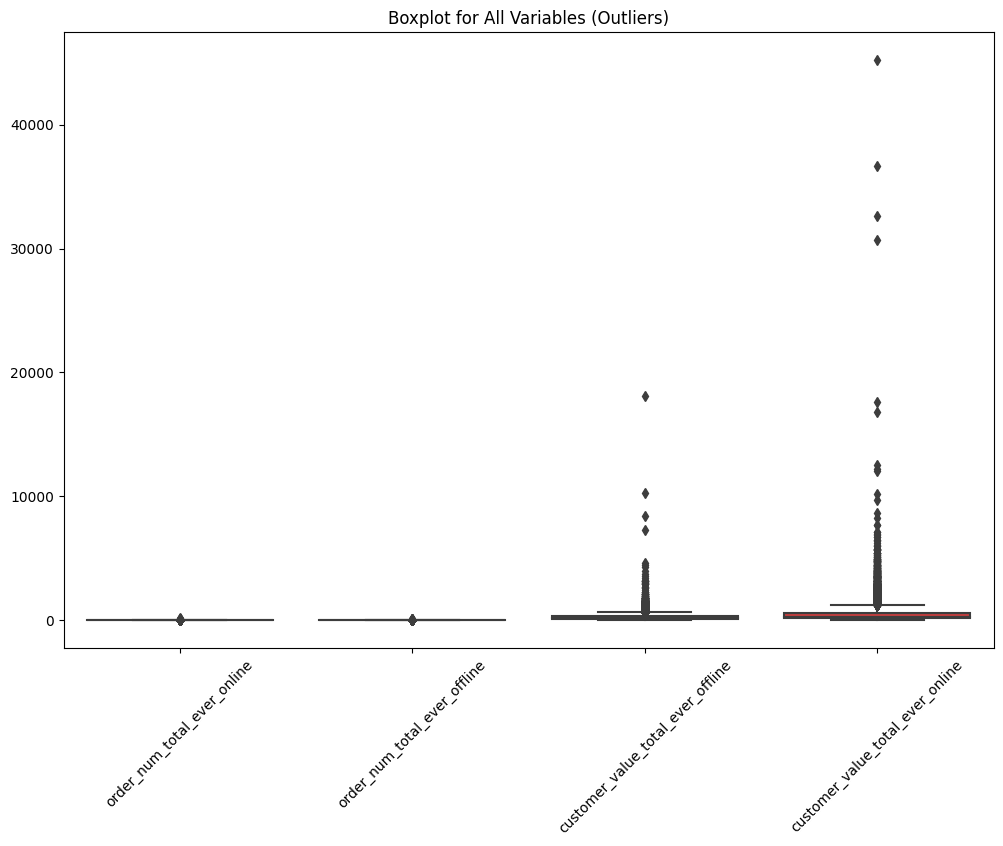

In [7]:
# Looking for Outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot for All Variables (Outliers)")
plt.show()

In [8]:
df.describe([0, 0.10, 0.25, 0.50, 0.75, 0.85, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,10%,25%,50%,75%,85%,95%,99%,100%,max
order_num_total_ever_online,19945.000,3.111,4.226,1.000,1.000,1.000,1.000,2.000,4.000,5.000,10.000,20.000,200.000,200.000
order_num_total_ever_offline,19945.000,1.914,2.063,1.000,1.000,1.000,1.000,1.000,2.000,3.000,4.000,7.000,109.000,109.000
customer_value_total_ever_offline,19945.000,253.923,301.533,10.000,10.000,59.990,99.990,179.980,319.970,429.896,694.222,1219.947,18119.140,18119.140
customer_value_total_ever_online,19945.000,497.322,832.602,12.990,12.990,84.990,149.980,286.460,578.440,844.828,1556.726,3143.810,45220.130,45220.130


As we can see, the outliers are gathered in the 99% range. That's why we set our upper limit to 99%.

In [9]:
# 1. Handle Outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [10]:
# In order not to lose customers, we set outliers equal to the upper limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit.round()
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit.round()

In [11]:
# Apply outlier treatment to key metrics
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

In [12]:
df.describe([0, 0.10, 0.25, 0.50, 0.75, 0.85, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,10%,25%,50%,75%,85%,95%,99%,100%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,1.000,1.000,2.000,4.000,5.000,10.000,20.000,48.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,1.000,1.000,2.000,3.000,4.000,7.000,16.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,10.000,59.990,99.990,179.980,319.970,429.896,694.222,1219.947,3020.000,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,12.990,84.990,149.980,286.460,578.440,844.828,1556.726,3143.810,7800.000,7800.000


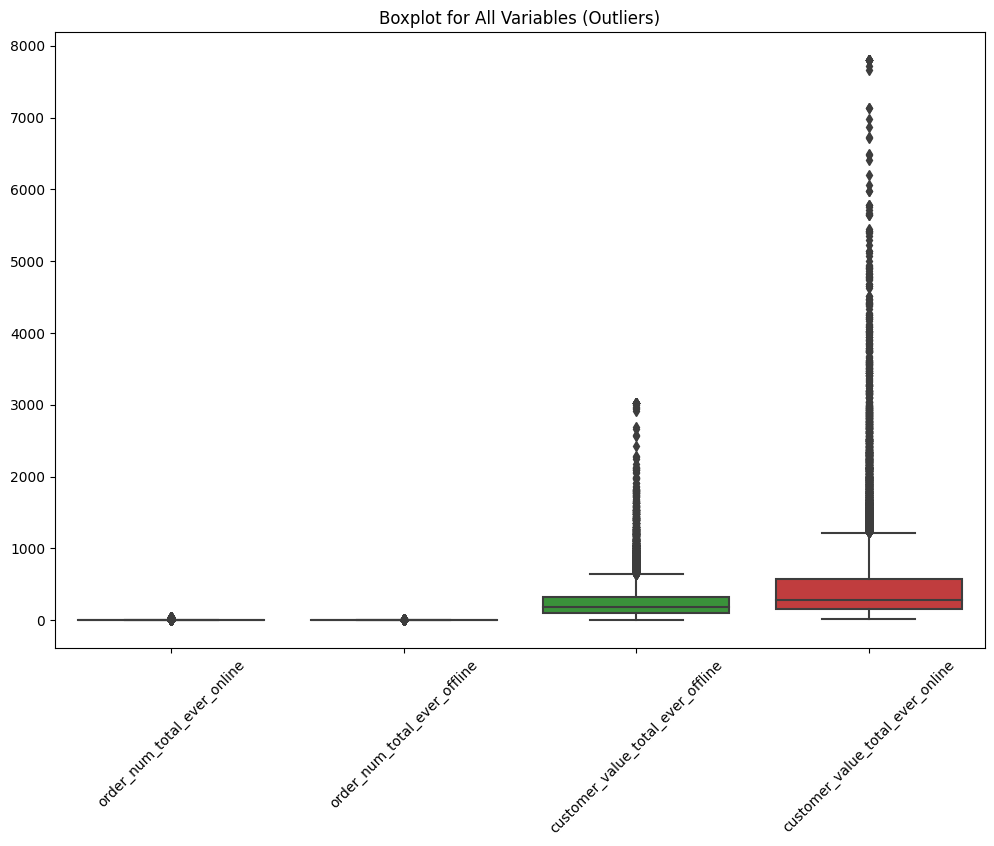

In [13]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot for All Variables (Outliers)")
plt.show()

In [14]:
# 2. Create Total Spending and Order Count Features
df["total_order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_value"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"]

In [15]:
# 3. Convert Date Columns to DateTime
date_cols = [col for col in df.columns if 'date' in col.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# **CLTV Data Structure Preparation**

In [16]:
# Set Analysis Date
analysis_date = df['last_order_date'].max() + dt.timedelta(days=2)

In [17]:
# Create CLTV DataFrame
df['recency'] = (df['last_order_date'] - df['first_order_date'])

cltv_df = df.groupby('master_id').agg(
    {'recency' : lambda x: x.dt.days,
     'first_order_date': [lambda date: (analysis_date - date.min()).days],
     'total_order' : lambda x: x,
     'total_value': lambda x: x})

In [18]:
# Convert to weekly basis
cltv_df.columns = ['recency_days', 'T_days', 'frequency', 'monetary']
cltv_df['recency_weekly'] = cltv_df['recency_days'] // 7
cltv_df['T_weekly'] = cltv_df['T_days'] // 7
cltv_df['monetary_avg'] = cltv_df['monetary'] / cltv_df['frequency']

In [19]:
# Filter active customers
cltv_df = cltv_df[cltv_df['frequency'] > 1]

# **Model Implementation**

In [20]:
# 1. BG-NBD Model for Purchase Prediction
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_weekly'],
        cltv_df['T_weekly'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 75.49, b: 0.00, r: 3.65>

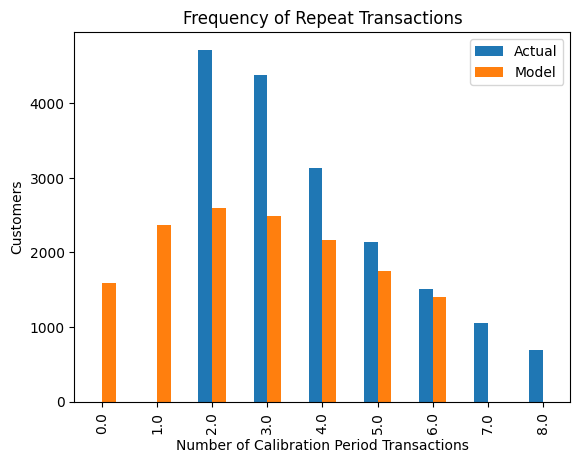

In [21]:
# the success of our model
plot_period_transactions(bgf)
plt.show()

In [22]:
# Predict purchases for next 3 & 6 months
cltv_df['exp_sales_3_month'] = bgf.predict(12,  # 12 weeks
                                          cltv_df['frequency'],
                                          cltv_df['recency_weekly'],
                                          cltv_df['T_weekly'])
cltv_df['exp_sales_6_month'] = bgf.predict(24,  # 24 weeks
                                          cltv_df['frequency'],
                                          cltv_df['recency_weekly'],
                                          cltv_df['T_weekly'])

In [23]:
# 2. Gamma-Gamma Model for Monetary Value
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_avg'])
cltv_df['exp_avg_value'] = ggf.conditional_expected_average_profit(
    cltv_df['frequency'],
    cltv_df['monetary_avg']
)

In [24]:
# 3. Calculate 6-month CLTV
cltv = ggf.customer_lifetime_value(
    bgf,
    cltv_df['frequency'],
    cltv_df['recency_weekly'],
    cltv_df['T_weekly'],
    cltv_df['monetary_avg'],
    time=6,  # 6 months
    freq='W'
)
cltv_df['cltv_6_month'] = cltv.values

# **Segmentation & Visualization**

In [25]:
# 1. Create CLTV Segments
cltv_df['cltv_segment'] = pd.qcut(cltv_df['cltv_6_month'], 
                                 q=4, 
                                 labels=['Bronze', 'Silver', 'Gold', 'Platinum'])

In [26]:
cltv_df.head()

,recency_days,T_days,frequency,monetary,recency_weekly,T_weekly,monetary_avg,exp_sales_3_month,exp_sales_6_month,exp_avg_value,cltv_6_month,cltv_segment
master_id,,,,,,,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,550,560,5.000,776.070,78,80,155.214,0.668,1.335,160.117,224.283,Gold
00034aaa-a838-11e9-a2fc-000d3a38a36f,1733,2031,3.000,269.470,247,290,89.823,0.218,0.437,95.234,43.630,Bronze
000be838-85df-11ea-a90b-000d3a38a36f,198,411,4.000,722.690,28,58,180.673,0.688,1.375,187.681,270.815,Platinum
000c1fe2-a8b7-11ea-8479-000d3a38a36f,332,359,7.000,874.160,47,51,124.880,1.010,2.021,127.793,270.924,Platinum
000f5e3e-9dde-11ea-80cd-000d3a38a36f,303,323,7.000,1620.330,43,46,231.476,1.052,2.104,236.368,521.730,Platinum


In [27]:
# Comparison of segments
cltv_df.groupby("cltv_segment").agg(["count", "mean", "sum"])

recency_days                  T_days                   frequency  \
                    count    mean      sum  count     mean      sum     count   
cltv_segment                                                                    
Bronze               4987 974.009  4857383   4987 1136.359  5667020      4987   
Silver               4986 648.615  3233995   4986  790.199  3939932      4986   
Gold                 4986 573.490  2859419   4986  701.500  3497677      4986   
Platinum             4986 471.203  2349416   4986  577.087  2877356      4986   

                             monetary                      recency_weekly  \
              mean       sum    count     mean         sum          count   
cltv_segment                                                                
Bronze       3.770 18801.000     4987  352.070 1755775.010           4987   
Silver       4.407 21971.000     4986  530.273 2643939.820           4986   
Gold         5.098 25418.000     4986  754.169 3760288.390           4986   
Platinum     6.638 33099.000     4986 1330.074 6631747.220           4986   

                             T_weekly                 monetary_avg          \
                mean     sum    count    mean     sum        count    mean   
cltv_segment                                                                 
Bronze       138.712  691757     4987 161.915  807468         4987  93.232   
Silver        92.231  459864     4986 112.465  560750         4986 125.864   
Gold          81.507  406393     4986  99.787  497536         4986 160.479   
Platinum      66.891  333517     4986  82.015  408929         4986 228.833   

                         exp_sales_3_month                exp_sales_6_month  \
                     sum             count  mean      sum             count   
cltv_segment                                                                  
Bronze        464947.494              4987 0.410 2045.060              4987   
Silver        627555.959              4986 0.528 2631.186              4986   
Gold          800149.304              4986 0.605 3016.060              4986   
Platinum     1140961.970              4986 0.778 3877.691              4986   

                            exp_avg_value                     cltv_6_month  \
              mean      sum         count    mean         sum        count   
cltv_segment                                                                 
Bronze       0.820 4090.119          4987  98.774  492584.758         4987   
Silver       1.055 5262.372          4986 132.327  659783.927         4986   
Gold         1.210 6032.120          4986 167.829  836793.360         4986   
Platinum     1.555 7755.382          4986 238.037 1186850.369         4986   

                                  
                mean         sum  
cltv_segment                      
Bronze        80.624  402069.841  
Silver       138.933  692721.617  
Gold         200.540  999891.722  
Platinum     364.571 1817752.825

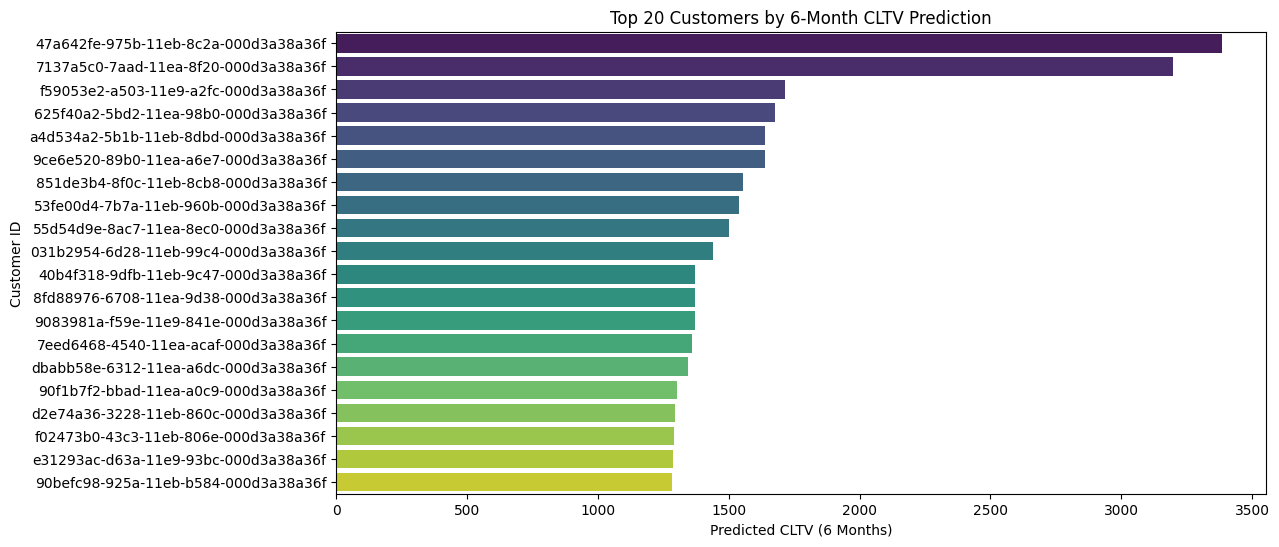

In [28]:
# 2. Top Customers Visualization
plt.figure(figsize=(12,6))
top_customers = cltv_df.sort_values('cltv_6_month', ascending=False).head(20)
sns.barplot(x=top_customers['cltv_6_month'], 
            y=top_customers.index, 
            palette='viridis')
plt.title('Top 20 Customers by 6-Month CLTV Prediction')
plt.xlabel('Predicted CLTV (6 Months)')
plt.ylabel('Customer ID')
plt.show()

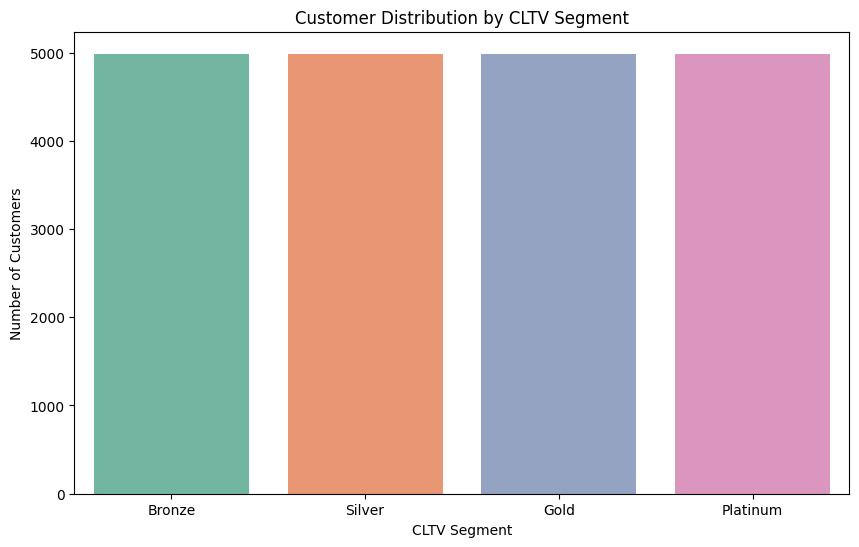

In [29]:
# 3. Segment Distribution
plt.figure(figsize=(10,6))
segment_dist = cltv_df['cltv_segment'].value_counts()
sns.barplot(x=segment_dist.index, y=segment_dist.values, palette='Set2')
plt.title('Customer Distribution by CLTV Segment')
plt.xlabel('CLTV Segment')
plt.ylabel('Number of Customers')
plt.show()

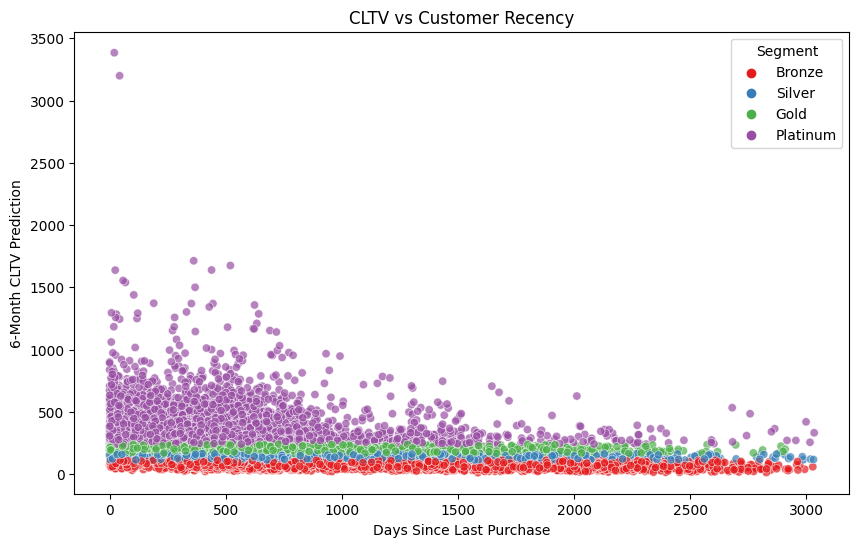

In [30]:
# 4. CLTV vs Recency Analysis
plt.figure(figsize=(10,6))
sns.scatterplot(data=cltv_df, 
                x='recency_days', 
                y='cltv_6_month', 
                hue='cltv_segment',
                palette='Set1',
                alpha=0.7)
plt.title('CLTV vs Customer Recency')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('6-Month CLTV Prediction')
plt.legend(title='Segment')
plt.show()

# **Make brief 6-month action recommendations to the management for 2 groups.**

**Platinum:** Since they are high-value customers, increasing their loyalty and establishing long-term relationships should be a priority. The spending potential of these customers can be supported with special privileges, personalized communication and cross-selling strategies.

**Bronze:** For customers with lower frequency and CLV, reactivation campaigns, customer experience improvements and targeted communication channels should be used to re-invigorate this group.